# [Task 1] Named Entity Recognition  |  LSTM  |  Keras

Import Libraries.

In [38]:
import re
import os
import json
import numpy as np
import pandas as pd
import seaborn as sns
from pprint import pprint
import matplotlib.pyplot as plt
from collections import Counter
from pandas.io.json import json_normalize

from keras.models import Model, Input
from keras.utils import to_categorical
from keras.preprocessing.sequence import pad_sequences
from keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional

from sklearn_crfsuite import metrics

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

In [2]:
%matplotlib inline
sns.set_style("dark")

## Util

Define class to read sentences one at a time.

In [3]:
class GetSentence(object):
    
    def __init__(self, data):
        self.i = 0
        self.id_list = np.unique(data['doc_id']).tolist()
        self.data = data
        
        agg_func = lambda x: [(w, t) for w, t in zip(x['word'].values.tolist(), x['obj'].values.tolist())]
        
        self.grouped_data = self.data.groupby('doc_id').apply(agg_func)
        self.sentences = [x for x in self.grouped_data]
        
    def get_next_sentence(self):
        try: 
            self.sentence = self.id_list[self.i]
            s = self.grouped_data[self.sentence]
            self.i += 1

            return s
        except:
            return None

Function to read json files.

In [4]:
def read_json(path):
    file = json.loads(open(path).read())
    
    return file

Function to extract words from text based on the indices.

In [5]:
def extract_word(begin, end, txt):
    return txt[begin:end]

In [6]:
base_dir = "../../data/AGAC_training-annotations/AGAC_training/json/"

## Prepare Data

BIO labelling of data.  

In [7]:
word_label_dict = {}

    
for f in os.listdir(base_dir):
    file = read_json(base_dir + f)
    # Extract the document ID from the file name
    doc_id = "".join(re.findall(r'\d', f))
    txt = file['text']


    for i in range(len(file['denotations'])):
        b = file['denotations'][i]['span']['begin']
        e = file['denotations'][i]['span']['end']
        word = extract_word(b, e, txt)
        word_split = word.split(' ')
        obj = file['denotations'][i]['obj']

        # If length of word (after splitting on " ") is more than 2
        # Put 'B/I' labels
        if len(word_split) == 2:
            b_word = word_split[0]
            i_word = word_split[-1]
            b_obj = "B-" + obj
            i_obj = "I-" + obj
            word_label_dict[i_word] = i_obj
            word_label_dict[b_word] = b_obj

        # If length of word (after splitting on " ") is equal to 1
        # Put a 'B' label
        else:
            b_word = word_split[0]
            b_obj = "B-" + obj

            word_label_dict[b_word] = b_obj

Clean the data and put the label 'O' where necessary.

In [8]:
final_list = []

for f in os.listdir(base_dir):
    file = read_json(base_dir + f)
    doc_id = "".join(re.findall(r'\d', f))
    txt = file['text']

    # Clean the text data
    txt = re.sub(r'\n', " ", txt)
    txt = re.sub(r'\.', "", txt)
    txt = re.sub(r',', "", txt)
    txt = re.sub(r':', "", txt)


    txt_split = txt.split(" ")

    # Put a label 'O' for words that do not appear
    # in word_label_dict
    for w in txt_split:
        if w in word_label_dict.keys():
            final_list.append((doc_id, w, word_label_dict[w]))
        else:
            final_list.append((doc_id, w, "O"))

In [9]:
data_df = pd.DataFrame(final_list, columns=['doc_id', 'word', 'obj'])

In [10]:
data_df.head()

,doc_id,word,obj
0,30442766,LZTR1,B-Gene
1,30442766,is,O
2,30442766,a,O
3,30442766,regulator,O
4,30442766,of,O


## EDA

### Count of words/obj per document.

In [11]:
data_df.groupby('doc_id').count().head()

,word,obj
doc_id,,
16371368,307,307
17435236,229,229
18031991,235,235
18594199,189,189
19338054,265,265


### Stats about the data.

In [12]:
data_df.describe()

,doc_id,word,obj
count,55808,55808,55808
unique,250,9744,25
top,28283687,of,O
freq,513,2206,35790


### Frequncy of different output labels.

Frequency with label 'O'.

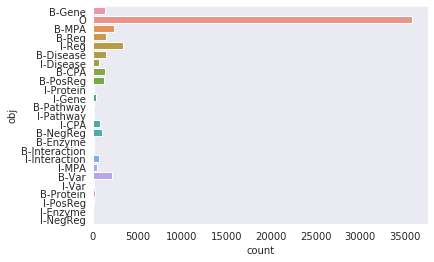

In [13]:
sns.countplot(y = "obj", data=data_df)

Frequency without label 'O'.

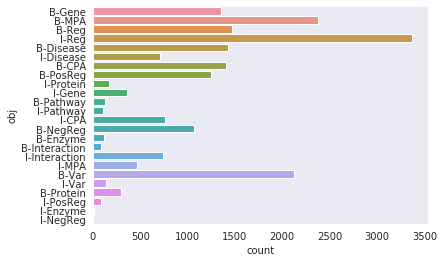

In [14]:
sns.countplot(y = "obj", data=data_df[data_df['obj'] != 'O'])

## Deep Learning - LSTM Keras

### Create a list of words and output tags

In [15]:
words = list(set(data_df["word"].values))
words.append("ENDPAD")
n_words = len(words)
print(f"Number of words = {n_words}")

Number of words = 9745


In [16]:
tags = list(set(data_df["obj"].values))
n_tags = len(tags)
print(f"Number of tags = {n_tags}")

Number of tags = 25


### Extract Sentences

In [17]:
getter = GetSentence(data_df)
sent = getter.get_next_sentence()

In [18]:
print(sent)

[('Effects', 'O'), ('of', 'O'), ('a', 'O'), ('leukemia-associated', 'O'), ('gain-of-function', 'B-PosReg'), ('mutation', 'B-Var'), ('of', 'O'), ('SHP-2', 'B-Gene'), ('phosphatase', 'B-Enzyme'), ('on', 'O'), ('interleukin-3', 'O'), ('signaling', 'B-MPA'), ('Mutations', 'B-Var'), ('in', 'I-Reg'), ('SHP-2', 'B-Gene'), ('phosphatase', 'B-Enzyme'), ('that', 'O'), ('cause', 'B-Reg'), ('hyperactivation', 'B-PosReg'), ('of', 'O'), ('its', 'O'), ('catalytic', 'B-Var'), ('activity', 'I-CPA'), ('have', 'B-PosReg'), ('been', 'O'), ('identified', 'B-Reg'), ('in', 'I-Reg'), ('human', 'B-CPA'), ('leukemias', 'I-Disease'), ('particularly', 'O'), ('juvenile', 'B-Disease'), ('myelomonocytic', 'O'), ('leukemia', 'I-Disease'), ('which', 'O'), ('is', 'O'), ('characterized', 'O'), ('by', 'I-Reg'), ('hypersensitivity', 'O'), ('of', 'O'), ('myeloid', 'O'), ('progenitor', 'B-CPA'), ('cells', 'B-CPA'), ('to', 'I-Reg'), ('granulocyte', 'O'), ('macrophage', 'O'), ('colony-stimulating', 'O'), ('factor', 'O'), ('an

In [19]:
sentences = getter.sentences

### Number of words per sentence.

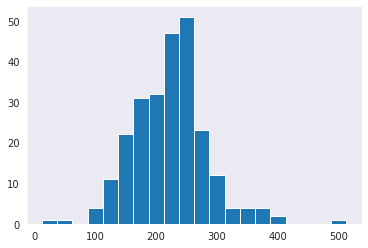

In [20]:
plt.hist([len(s) for s in sentences], bins=20)
plt.show()

Majority of the sentences have 250 words per sentence. So, we'll set the limit for max words as 250. Each sentence will be padded or stripped down to maintain 250 words.

### Create word/tag to id dictionary.

In [21]:
max_len = 250
word2idx = {w: i for i, w in enumerate(words)}
tag2idx = {t: i for i, t in enumerate(tags)}

In [22]:
print(word2idx['variations'])
print(tag2idx['O'])

993
0


### Pad sentences.

In [23]:
X = [[word2idx[w[0]] for w in s] for s in sentences]

In [24]:
X = pad_sequences(maxlen=max_len, sequences=X, padding="post", value=n_words - 1)

### Pad tags.

In [25]:
y = [[tag2idx[w[1]] for w in s] for s in sentences]

In [26]:
y = pad_sequences(maxlen=max_len, sequences=y, padding="post", value=tag2idx["O"])

### Convert tags to categorical values.

In [27]:
y = [to_categorical(i, num_classes=n_tags) for i in y]

### Split data into train and test sets.

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

### Define NN architecture.

In [31]:
inp = Input(shape=(max_len,))
model = Embedding(input_dim=n_words, output_dim=90, input_length=max_len)(inp)
model = Dropout(0.1)(model)
model = Bidirectional(LSTM(units=120, return_sequences=True, recurrent_dropout=0.1))(model)
out = TimeDistributed(Dense(n_tags, activation="softmax"))(model)  

In [32]:
model = Model(inp, out)

In [34]:
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

### Train the model.

In [35]:
history = model.fit(X_train, np.array(y_train), batch_size=32, epochs=80, validation_split=0.1, verbose=1)

W0715 09:54:05.839657 140224608380736 deprecation.py:323] From /home/akshaj/anaconda3/envs/nlp/lib/python3.6/site-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 202 samples, validate on 23 samples
Epoch 1/80
202/202 [==============================] - 6s 28ms/step - loss: 3.1355 - acc: 0.5862 - val_loss: 2.9103 - val_acc: 0.6927
Epoch 2/80
202/202 [==============================] - 3s 16ms/step - loss: 2.2434 - acc: 0.6957 - val_loss: 1.7886 - val_acc: 0.6927
Epoch 3/80
202/202 [==============================] - 3s 16ms/step - loss: 1.5799 - acc: 0.6957 - val_loss: 1.5310 - val_acc: 0.6927
Epoch 4/80
202/202 [==============================] - 3s 16ms/step - loss: 1.4957 - acc: 0.6957 - val_loss: 1.4423 - val_acc: 0.6927
Epoch 5/80
202/202 [==============================] - 4s 19ms/step - loss: 1.4179 - acc: 0.6957 - val_loss: 1.4149 - val_acc: 0.6927
Epoch 6/80
202/202 [==============================] - 3s 15ms/step - loss: 1.3908 - acc: 0.6957 - val_loss: 1.3783 - val_acc: 0.6927
Epoch 7/80
202/202 [==============================] - 3s 16ms/step - loss: 1.3556 - acc: 0.6957 - val_loss: 1.3525 - val_acc: 0.6927
Epoch 8/80
202/202 [====

Epoch 62/80
202/202 [==============================] - 3s 15ms/step - loss: 0.0086 - acc: 0.9998 - val_loss: 0.1697 - val_acc: 0.9699
Epoch 63/80
202/202 [==============================] - 3s 15ms/step - loss: 0.0081 - acc: 0.9998 - val_loss: 0.1694 - val_acc: 0.9699
Epoch 64/80
202/202 [==============================] - 3s 16ms/step - loss: 0.0076 - acc: 0.9998 - val_loss: 0.1696 - val_acc: 0.9699
Epoch 65/80
202/202 [==============================] - 3s 15ms/step - loss: 0.0072 - acc: 0.9998 - val_loss: 0.1697 - val_acc: 0.9699
Epoch 66/80
202/202 [==============================] - 3s 16ms/step - loss: 0.0068 - acc: 0.9998 - val_loss: 0.1693 - val_acc: 0.9697
Epoch 67/80
202/202 [==============================] - 3s 15ms/step - loss: 0.0065 - acc: 0.9998 - val_loss: 0.1690 - val_acc: 0.9699
Epoch 68/80
202/202 [==============================] - 3s 15ms/step - loss: 0.0062 - acc: 0.9998 - val_loss: 0.1687 - val_acc: 0.9699
Epoch 69/80
202/202 [==============================] - 3s 15ms

### Train Acc and Val Acc.

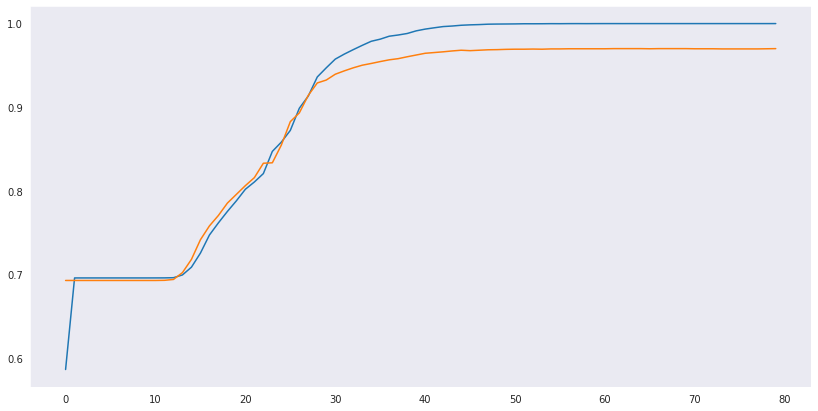

In [36]:
hist = pd.DataFrame(history.history)
plt.figure(figsize=(14,7))
plt.plot(hist["acc"])
plt.plot(hist["val_acc"])
plt.show()

### Classification Metrics.

In [39]:
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=-1)
y_t = np.array(np.argmax(y_test, axis=-1))

print(metrics.flat_classification_report(y_t, y_pred))

              precision    recall  f1-score   support

           0       0.96      1.00      0.98      4497
           1       0.98      0.93      0.95        55
           2       0.00      0.00      0.00         2
           3       1.00      1.00      1.00        10
           4       1.00      0.95      0.97        92
           5       1.00      0.87      0.93        70
           6       0.83      0.28      0.42        85
           8       0.99      0.89      0.94       210
           9       1.00      0.75      0.85        59
          10       1.00      0.92      0.96        95
          11       1.00      0.92      0.96       115
          12       1.00      1.00      1.00         9
          13       1.00      0.99      1.00       117
          14       1.00      1.00      1.00       312
          15       1.00      0.41      0.58        17
          16       1.00      0.96      0.98        26
          17       1.00      0.86      0.93       102
          18       1.00    

/home/akshaj/anaconda3/envs/nlp/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/akshaj/anaconda3/envs/nlp/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/akshaj/anaconda3/envs/nlp/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


### Try out the model

In [40]:
i = 24
y_pred = model.predict(np.array([X_test[i]]))
y_pred = np.argmax(y_pred, axis=-1)
y_t = np.array(np.argmax(y_test[i], axis=-1))
print("Word : Predicted : Actual\n")

for w, pred, actual in zip(X_test[i], y_pred[0], y_t):
    pprint("{:25}: {:15}: {}".format(words[w], tags[pred], tags[actual]))

Word : Predicted : Actual

'HER2                     : B-Protein      : B-Protein'
'over-expression          : B-MPA          : B-MPA'
'is                       : O              : O'
'related                  : O              : O'
'with                     : I-Interaction  : I-Interaction'
'a                        : O              : O'
'poor                     : O              : O'
'prognosis                : O              : O'
'in                       : I-Reg          : I-Reg'
'patients                 : O              : O'
'with                     : I-Interaction  : I-Interaction'
'invasive                 : B-Disease      : B-Disease'
'breast                   : B-Disease      : B-Disease'
'cancer                   : B-Disease      : B-Disease'
'tumors                   : I-CPA          : I-CPA'
'Clinical                 : O              : O'
'associations             : O              : O'
'have                     : B-PosReg       : B-PosReg'
'reported                 : B-Reg 